# U-Net results analysis

In [1]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks import *

In [2]:
cwd = os.getcwd()
path = cwd
#path

In [3]:
# Choose the land classification level here
level = 1  # choose 1, 2 or 3

In [4]:
path_lbl = '../data/landuse_Level'+str(level)+'_bw'
path_img = '../data/sentinel2'

In [5]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('../data/sentinel2/landusage_est_77_39.png'),
 PosixPath('../data/sentinel2/landusage_est_21_44.png'),
 PosixPath('../data/sentinel2/landusage_est_03_05.png'),
 PosixPath('../data/sentinel2/landusage_est_61_44.png'),
 PosixPath('../data/sentinel2/landusage_est_78_79.png')]

In [6]:
label_names = get_image_files(path_lbl)
label_names[:5]

[PosixPath('../data/landuse_Level1_bw/landusage_est_77_39.png'),
 PosixPath('../data/landuse_Level1_bw/landusage_est_21_44.png'),
 PosixPath('../data/landuse_Level1_bw/landusage_est_03_05.png'),
 PosixPath('../data/landuse_Level1_bw/landusage_est_61_44.png'),
 PosixPath('../data/landuse_Level1_bw/landusage_est_78_79.png')]

In [7]:
codes = np.loadtxt('../data/codes_Level'+str(level)+'.txt', dtype=str,delimiter=';')

In [8]:
codes

array(['Tehisalad', 'Põllumajanduslikud alad', 'Metsad ja pool- looduslikud alad', 'Märgalad', 'Vesi'], dtype='<U32')

In [9]:
get_y_fn = lambda x: path_lbl+f'/{x.stem}{x.suffix}'

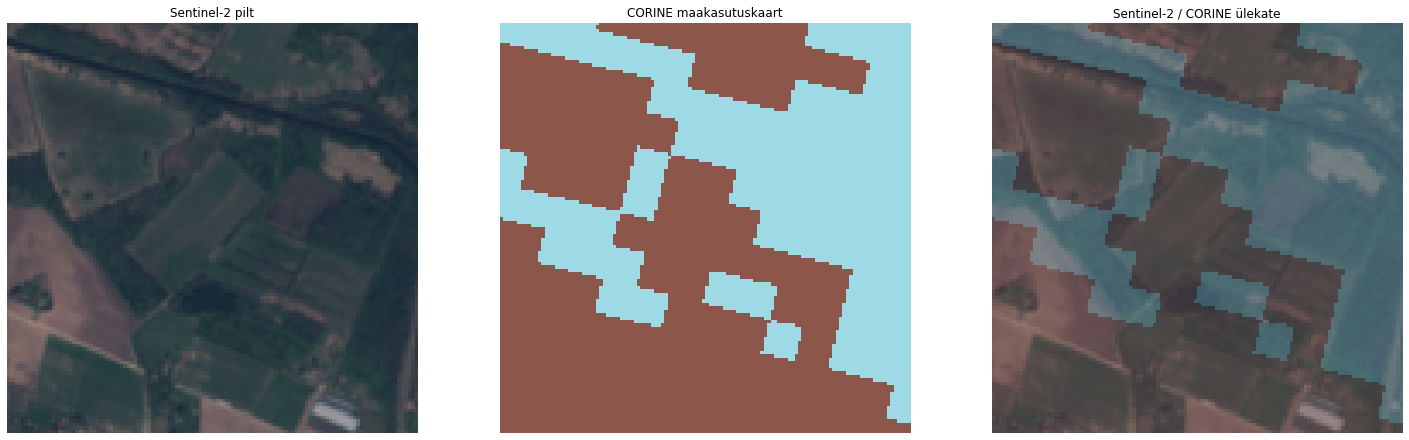

In [10]:
imgfn = fnames[60]
img = open_image(imgfn)
mask = open_mask(get_y_fn(imgfn))

_,axes = plt.subplots(1,3, figsize=(25,15))

img.show(ax=axes[0], title='Sentinel-2 pilt')
mask.show(ax=axes[1], alpha=1, title='CORINE maakasutuskaart')
img.show(ax=axes[2], y=mask, alpha=0.3, title='Sentinel-2 / CORINE ülekate')

In [11]:
size = np.array(mask.shape[1:])
bs = 16

In [12]:
src = (SegmentationItemList.from_folder(path_img)  # Load in x data from folder
       .split_by_rand_pct(seed=42)  # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)  # Label data using the get_y_fn function
      )

data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)  # Flip images horizontally and vertically
        .databunch(bs=bs)  # Create a databunch
        .normalize(imagenet_stats)  # Normalize for resnet
       )

In [13]:
def accuracy_seg(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [14]:
learn = unet_learner(data, models.resnet50, metrics=[accuracy_seg],callback_fns=[ShowGraph])

In [15]:
learn.load('Level'+str(level)+'-unet-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (6625 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Valid: LabelList (1656 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
     

In [16]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 60, 60]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 60, 60]         128        True      
______________________________________________________________________
ReLU                 [64, 60, 60]         0          False     
______________________________________________________________________
MaxPool2d            [64, 30, 30]         0          False     
______________________________________________________________________
Conv2d               [64, 30, 30]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 30, 30]         128        True      
______________________________________________________________________
Conv2d               [64, 30, 30]         36,864     False     
__________________________________________________

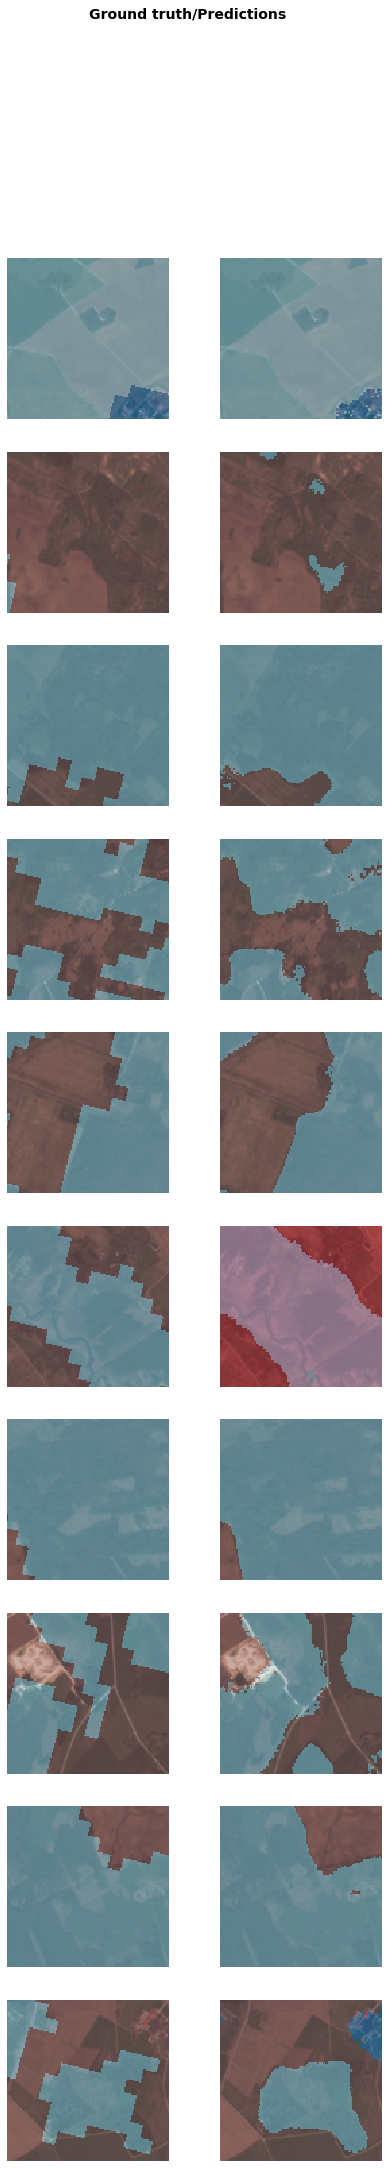

In [16]:
learn.show_results(rows=10, figsize=(7,35))

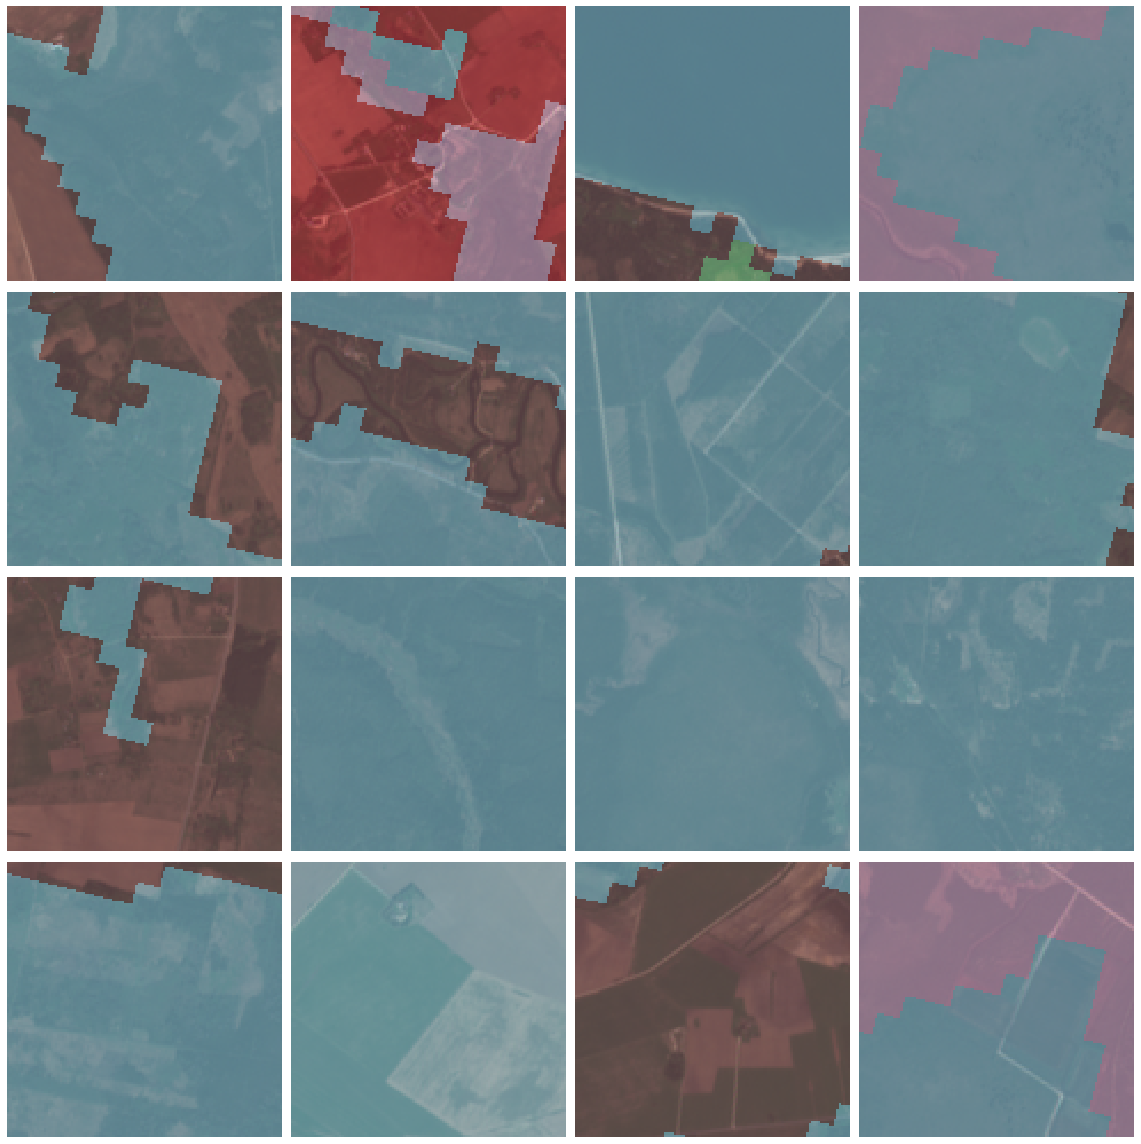

In [17]:
data.show_batch(ds_type=2)

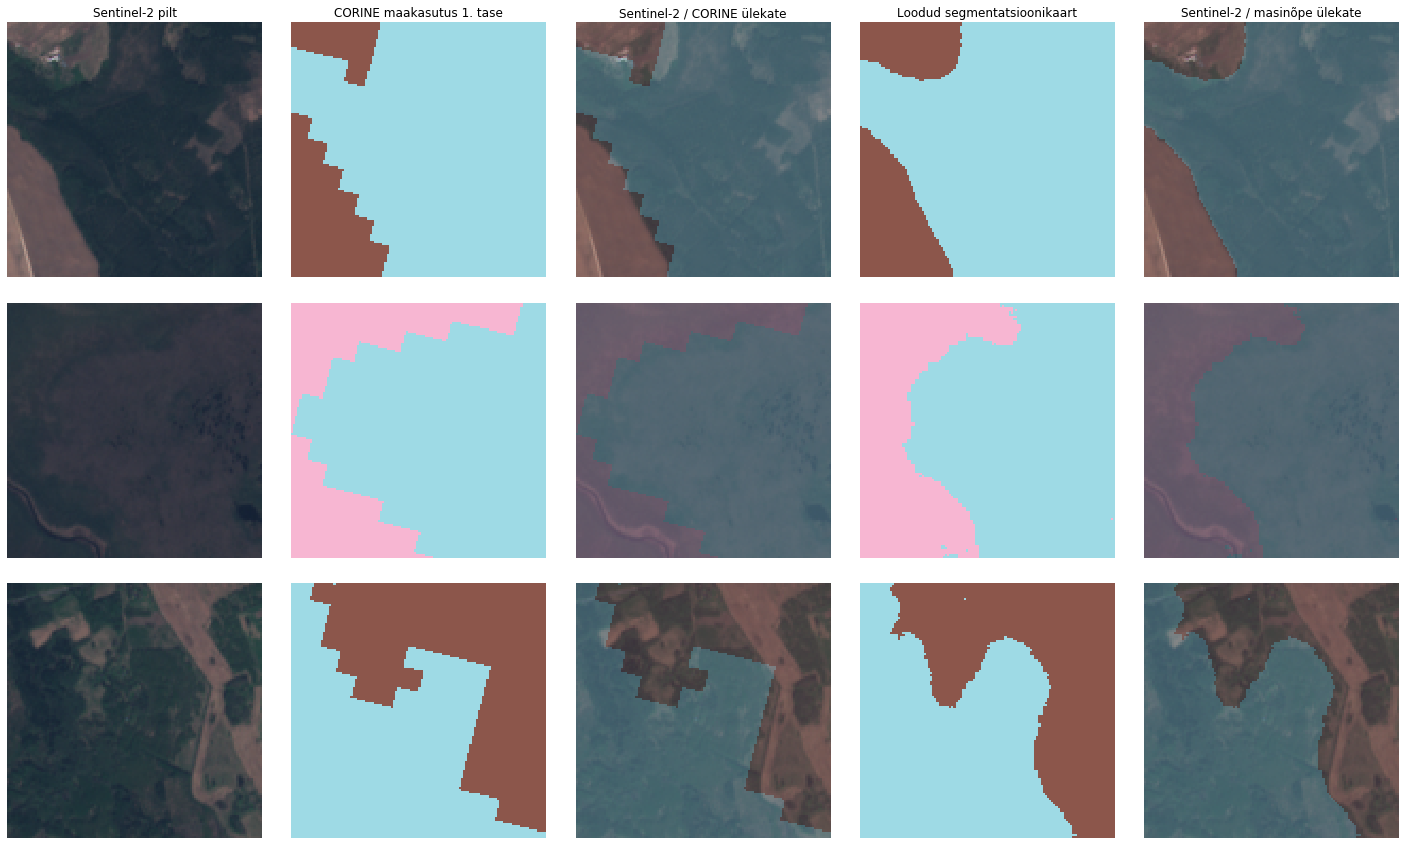

In [18]:
imgfn = fnames[0]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

cols = ['Sentinel-2 pilt','CORINE maakasutus 1. tase','Sentinel-2 / CORINE ülekate','Loodud segmentatsioonikaart','Sentinel-2 / masinõpe ülekate']
_,axes = plt.subplots(3,5, figsize=(25,15))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
img.show(ax=axes[0,0])
mask.show(ax=axes[0,1], alpha=1)
img.show(ax=axes[0,2], y=mask, alpha=0.3)
prediction.show(ax=axes[0,3], alpha=1)
img.show(ax=axes[0,4], y=prediction, alpha=0.3)

imgfn = fnames[3]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

img.show(ax=axes[1,0])
mask.show(ax=axes[1,1], alpha=1)
img.show(ax=axes[1,2], y=mask, alpha=0.3)
prediction.show(ax=axes[1,3], alpha=1)
img.show(ax=axes[1,4], y=prediction, alpha=0.3)

imgfn = fnames[4]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

img.show(ax=axes[2,0])
mask.show(ax=axes[2,1], alpha=1)
img.show(ax=axes[2,2], y=mask, alpha=0.3)
prediction.show(ax=axes[2,3], alpha=1)
img.show(ax=axes[2,4], y=prediction, alpha=0.3)

In [19]:
interp = SegmentationInterpretation.from_learner(learn)

In [20]:
top_losses, top_idxs = interp.top_losses(sizes=(120,120))

In [21]:
mean_cm, single_img_cm = interp._generate_confusion()

# Overall confusion matrices

## Level 1

label,score
Metsad ja pool- looduslikud alad,0.858622
Vesi,0.825253
Põllumajanduslikud alad,0.769698
Tehisalad,0.416175
Märgalad,0.400048


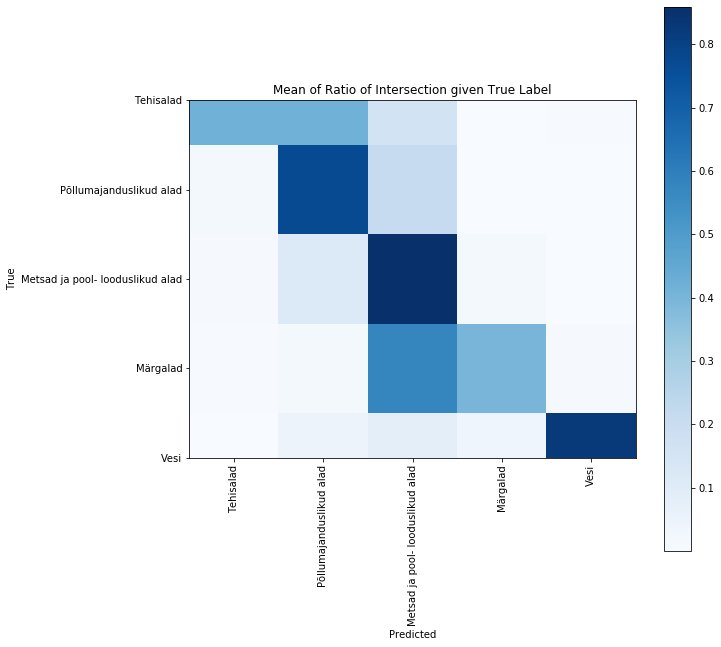

In [22]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

## Level 2

label,score
Metsad,0.866452
Siseveed,0.804551
Põllumaa,0.75734
Sisemaal olevad märgalad,0.464905
Asustatud alad,0.416278
Mereveed,0.356489
Heterogeensed põllumaj.-piirkonnad,0.297583
Karjamaad,0.281906
"Tööstus -, äri - ja transport",0.178846
Võsa ja / või rohttaimest ühend.,0.156211


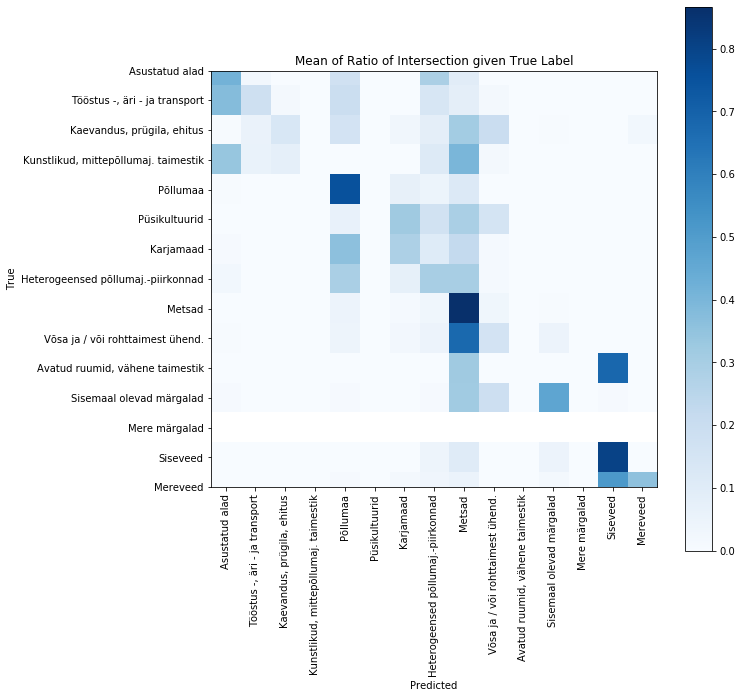

In [50]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

## Level 3

label,score
Niisutuseta haritav maa,0.786826
Veekogud,0.656616
Meri ja ookean,0.637598
Segametsad,0.619156
Turbaraba,0.511456
Okasmetsad,0.489613
Hõredalt hoonestatud alad,0.484076
Karjamaad,0.285407
Põllumajanduslik maa,0.263679
Üleminekuline metsaala,0.184514


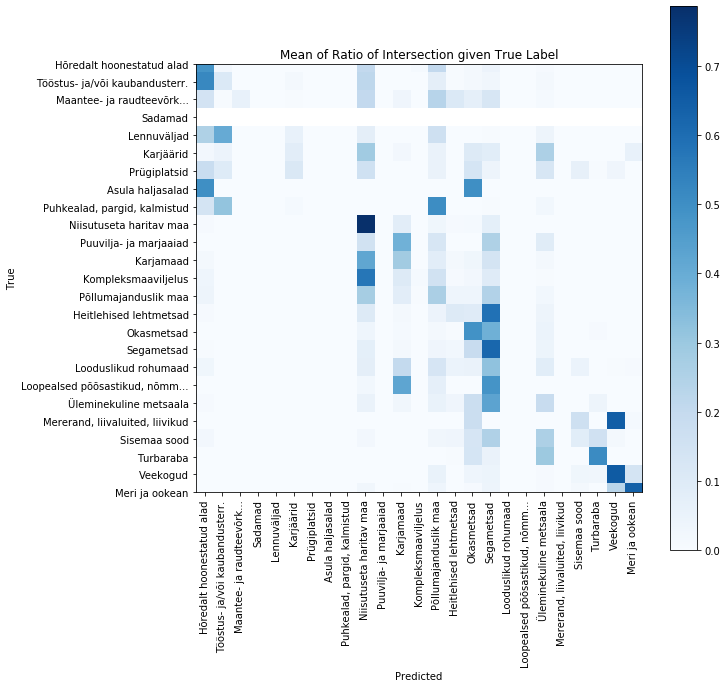

In [22]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

# Examples

## Level 1

label,score
Metsad ja pool- looduslikud alad,0.985315
Põllumajanduslikud alad,0.790981
Tehisalad,NaN
Märgalad,NaN
Vesi,NaN


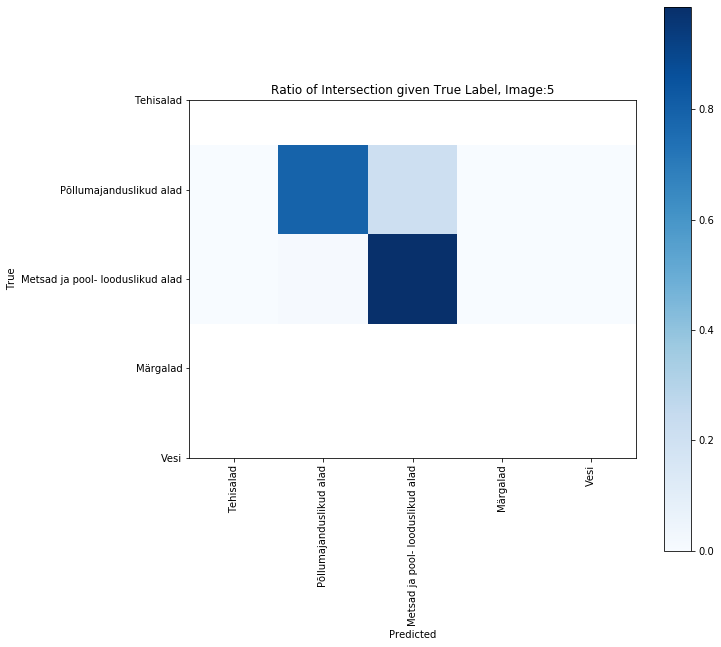

In [23]:
i=5
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

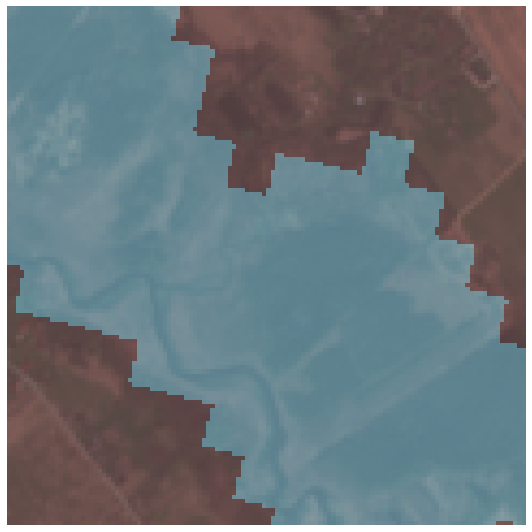

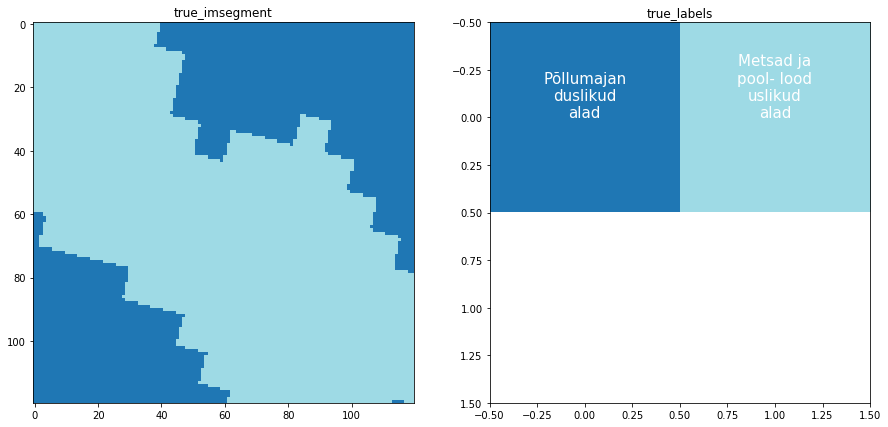

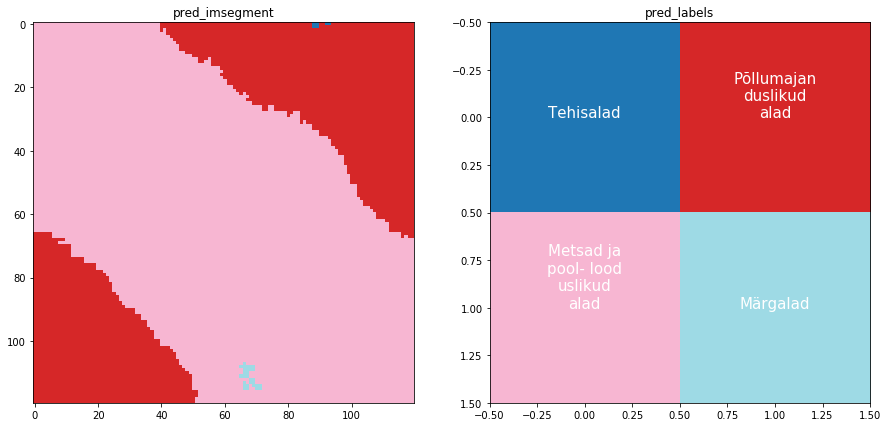

In [24]:
interp.show_xyz(i, sz=15)

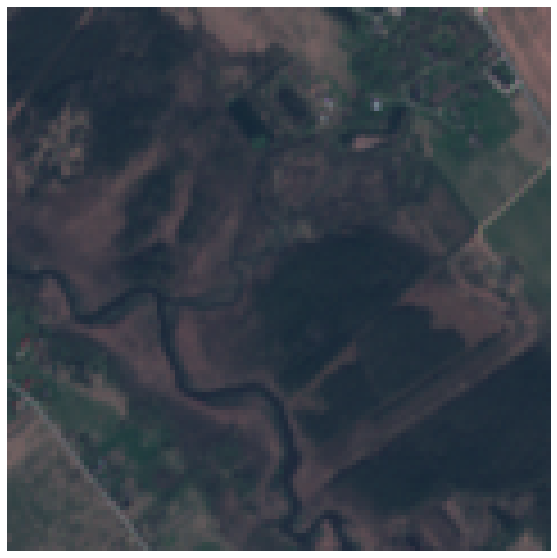

In [25]:
im = open_image(data.valid_ds.items[i])
im.show(figsize=(10, 10))

label,score
Metsad ja pool- looduslikud alad,0.90005
Põllumajanduslikud alad,0.701451
Tehisalad,NaN
Märgalad,NaN
Vesi,NaN


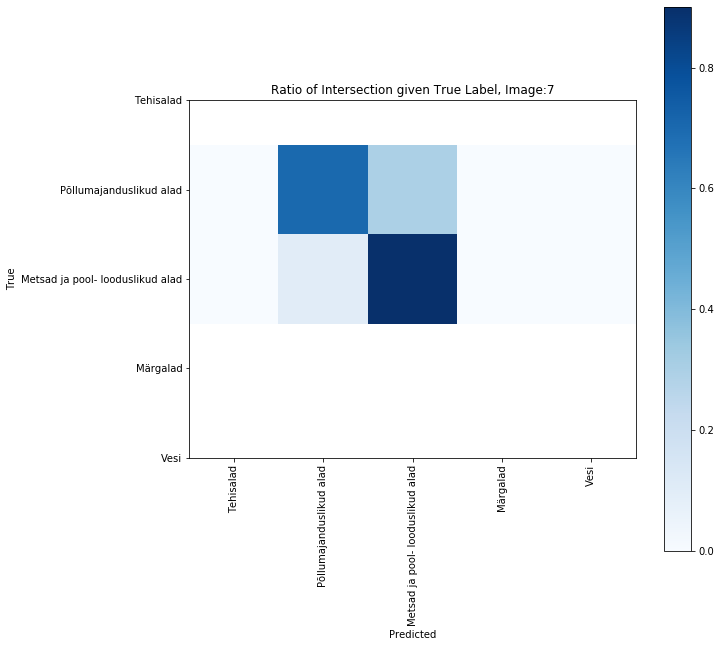

In [26]:
i=7
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

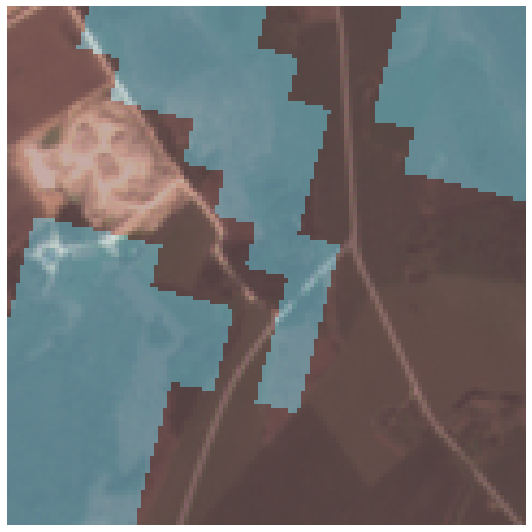

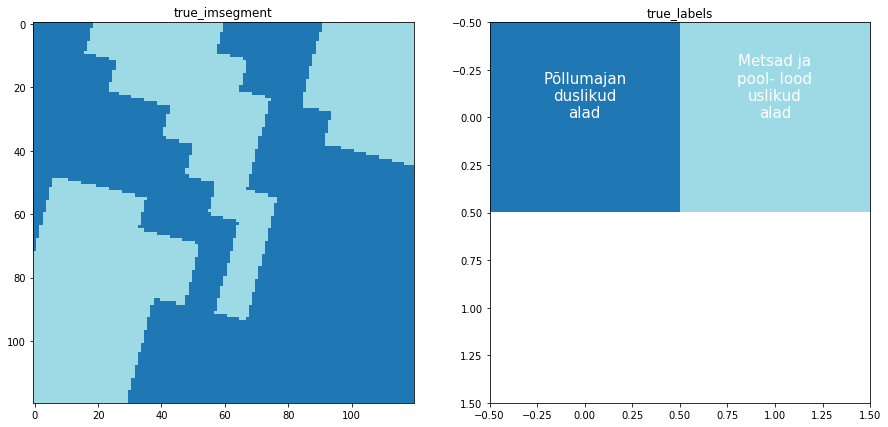

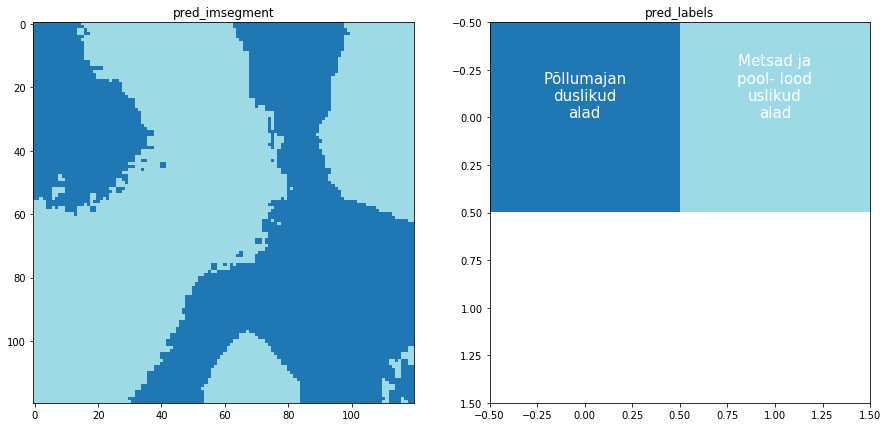

In [27]:
interp.show_xyz(i, sz=15)

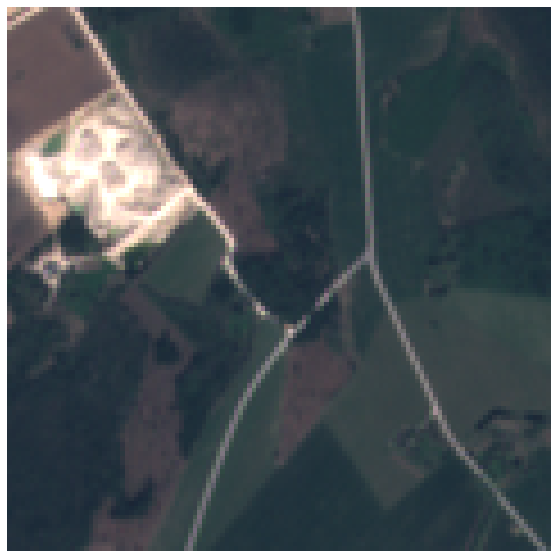

In [28]:
im = open_image(data.valid_ds.items[i])
im.show(figsize=(10, 10))

## Level 2

label,score
Metsad,0.962518
Põllumaa,0.813636
Heterogeensed põllumaj.-piirkonnad,0.623285
Võsa ja / või rohttaimest ühend.,0.389423
Karjamaad,0.345351
Asustatud alad,NaN
"Tööstus -, äri - ja transport",NaN
"Kaevandus, prügila, ehitus",NaN
"Kunstlikud, mittepõllumaj. taimestik",NaN
Püsikultuurid,NaN


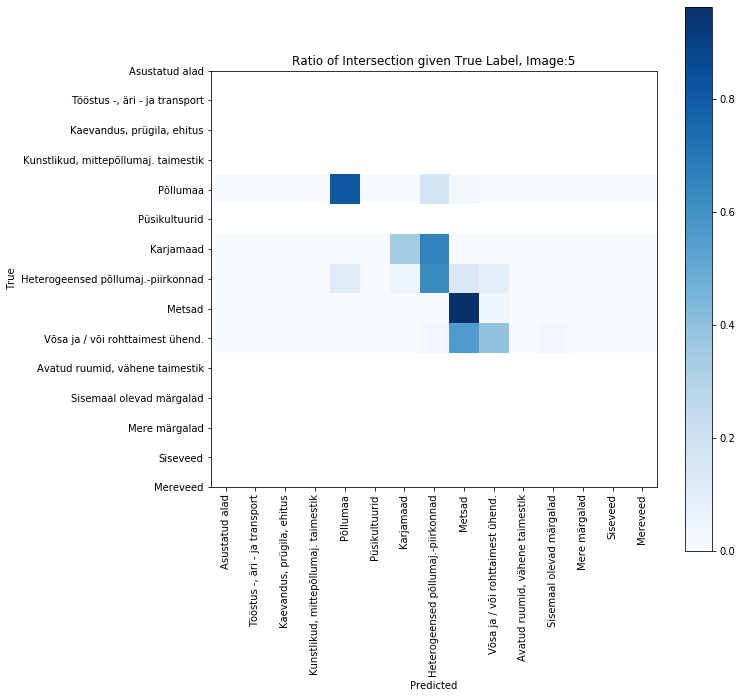

In [51]:
i=5
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

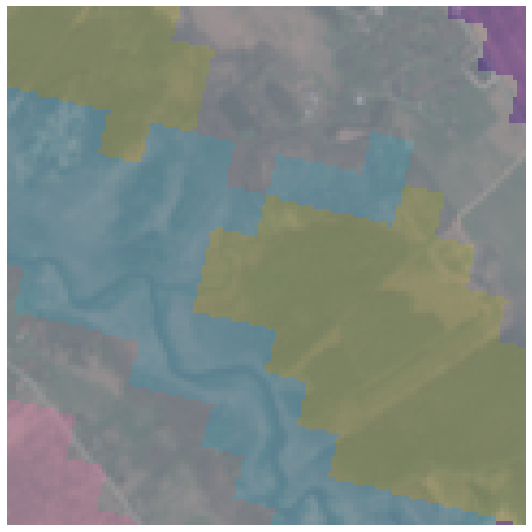

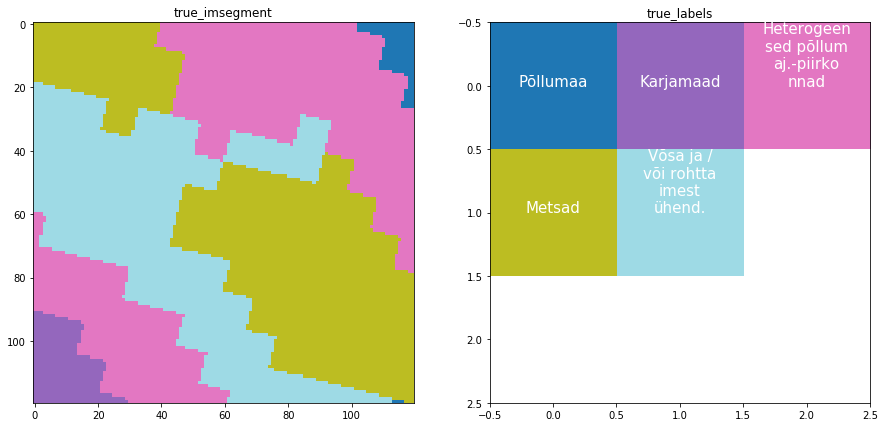

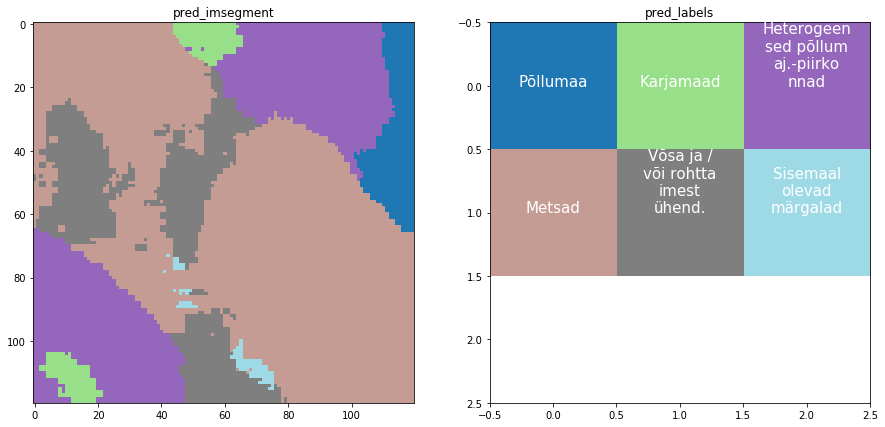

In [52]:
interp.show_xyz(i, sz=15)

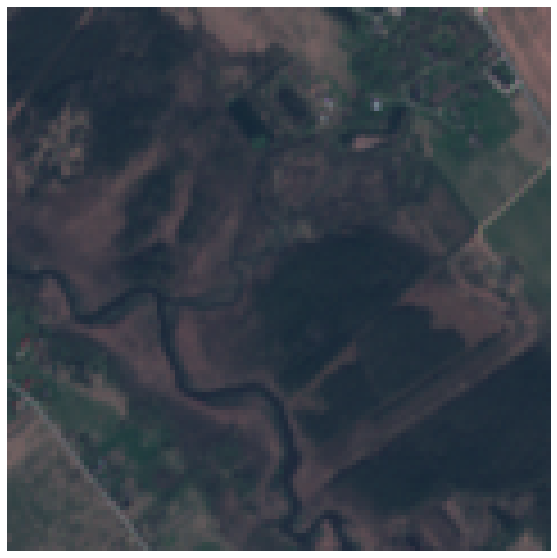

In [53]:
im = open_image(data.valid_ds.items[i])
im.show(figsize=(10, 10))

label,score
Metsad,0.806696
Põllumaa,0.490344
Asustatud alad,NaN
"Tööstus -, äri - ja transport",NaN
"Kaevandus, prügila, ehitus",NaN
"Kunstlikud, mittepõllumaj. taimestik",NaN
Püsikultuurid,NaN
Karjamaad,NaN
Heterogeensed põllumaj.-piirkonnad,NaN
Võsa ja / või rohttaimest ühend.,NaN


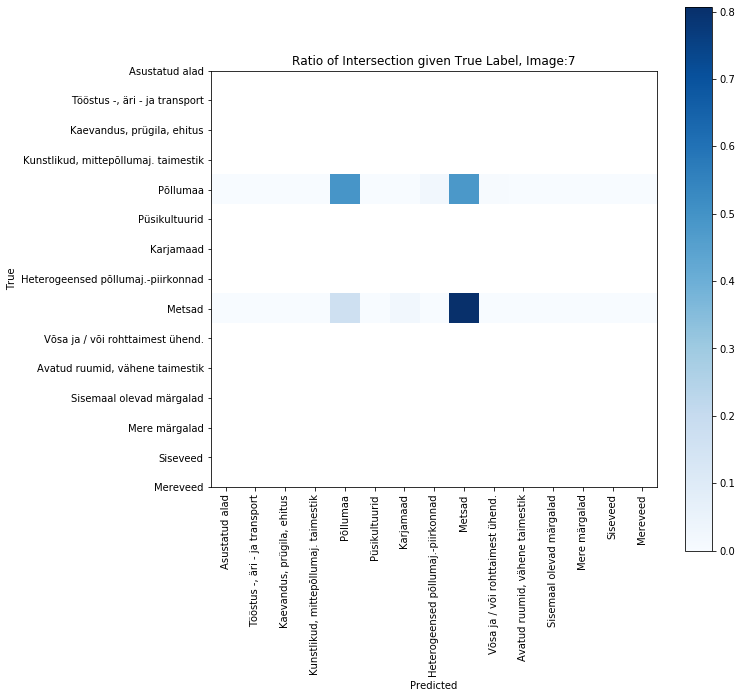

In [54]:
i=7
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

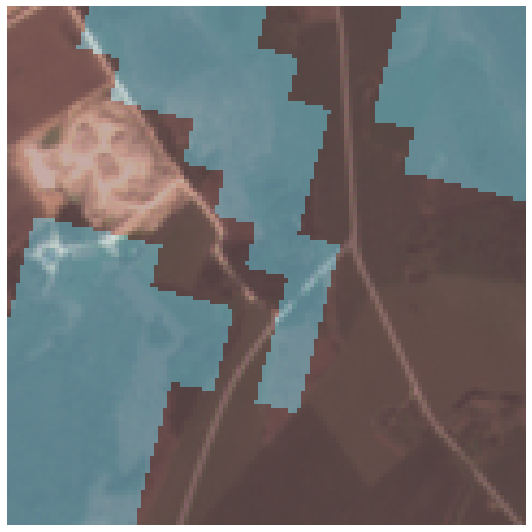

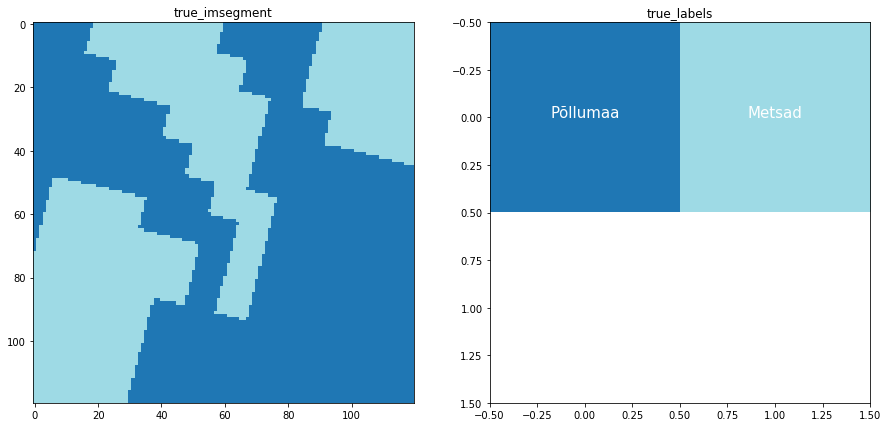

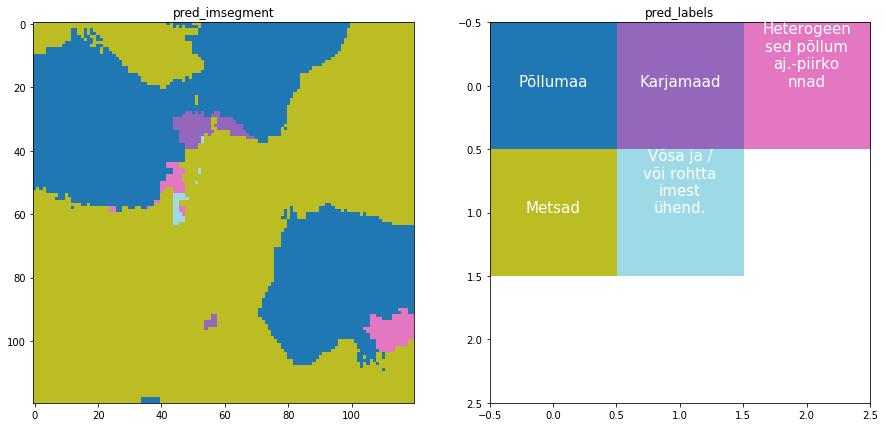

In [55]:
interp.show_xyz(i, sz=15)

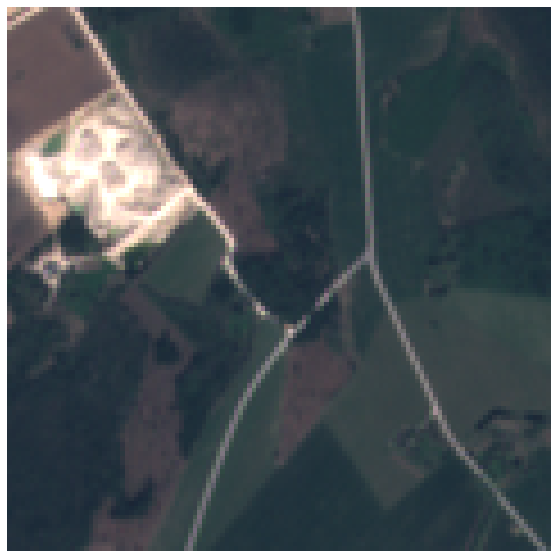

In [56]:
im = open_image(data.valid_ds.items[i])
im.show(figsize=(10, 10))

## Level 3

label,score
Okasmetsad,0.954335
Segametsad,0.93913
Niisutuseta haritav maa,0.859091
Karjamaad,0.802657
Üleminekuline metsaala,0.38774
Kompleksmaaviljelus,0.0135077
Hõredalt hoonestatud alad,NaN
Tööstus- ja/või kaubandusterr.,NaN
Maantee- ja raudteevõrk...,NaN
Sadamad,NaN


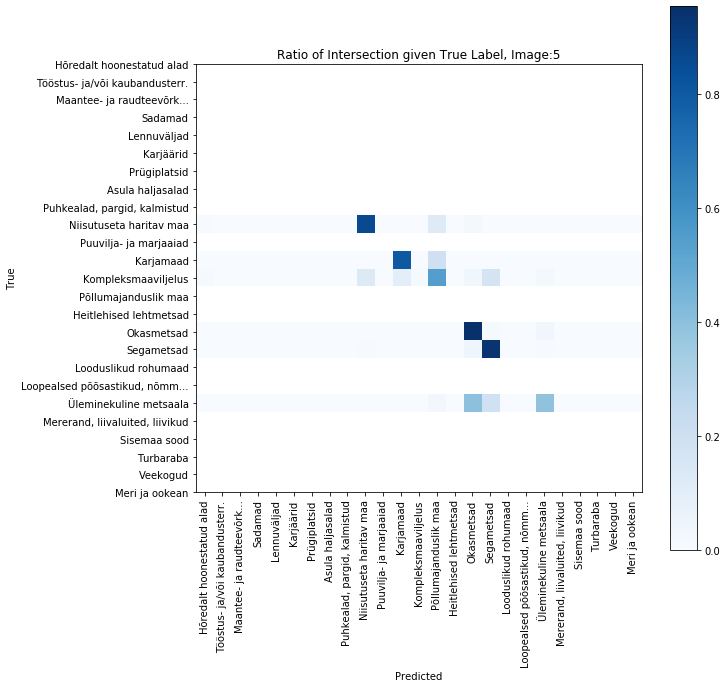

In [24]:
i=5
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

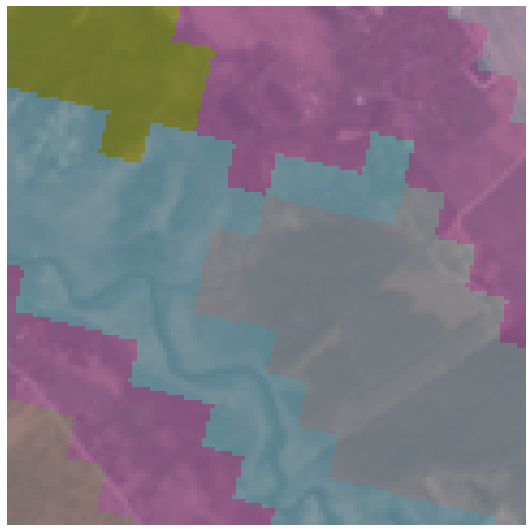

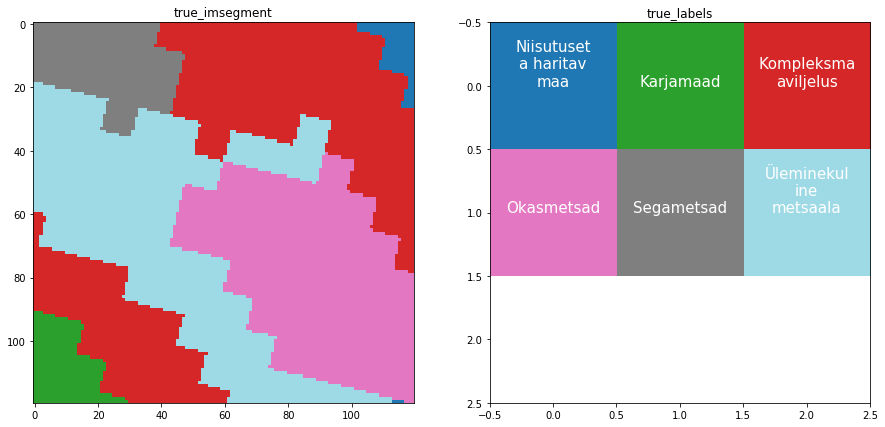

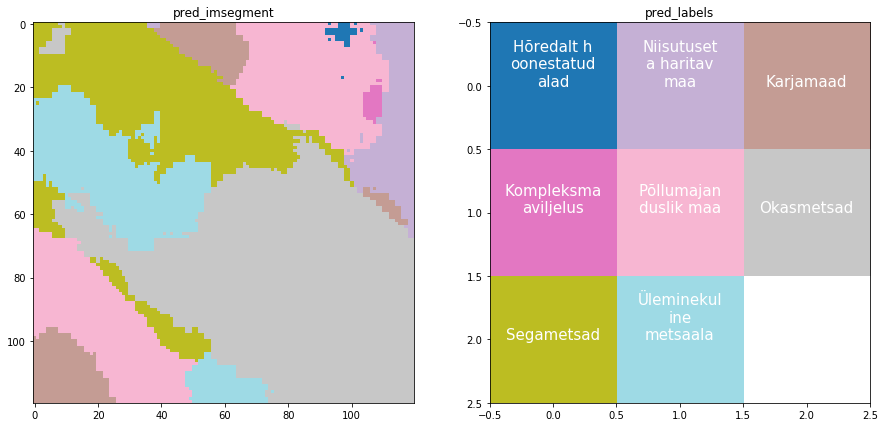

In [25]:
interp.show_xyz(i, sz=15)

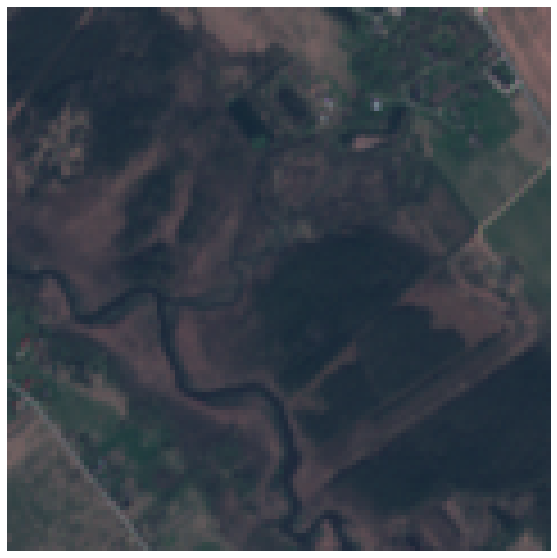

In [26]:
im = open_image(data.valid_ds.items[i])
im.show(figsize=(10, 10))

label,score
Niisutuseta haritav maa,0.804006
Segametsad,0.332211
Okasmetsad,0.0899591
Hõredalt hoonestatud alad,NaN
Tööstus- ja/või kaubandusterr.,NaN
Maantee- ja raudteevõrk...,NaN
Sadamad,NaN
Lennuväljad,NaN
Karjäärid,NaN
Prügiplatsid,NaN


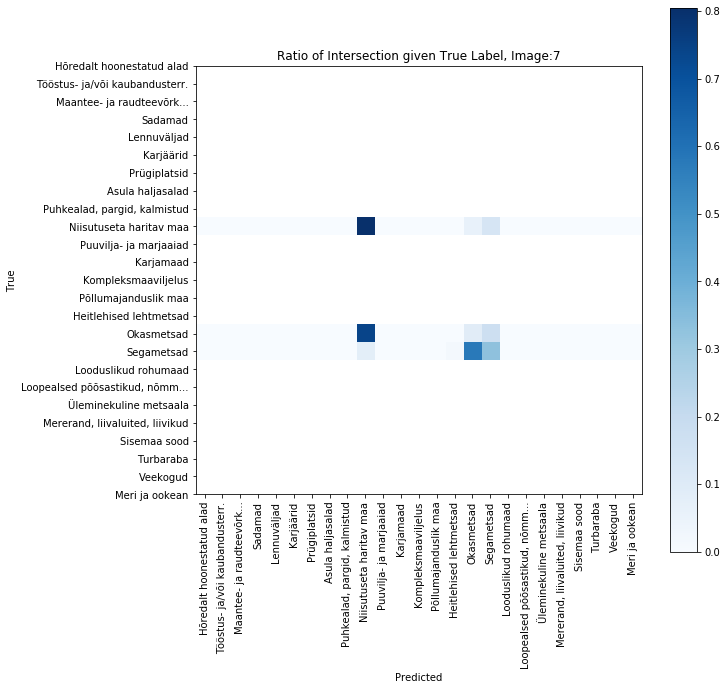

In [27]:
i=7
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

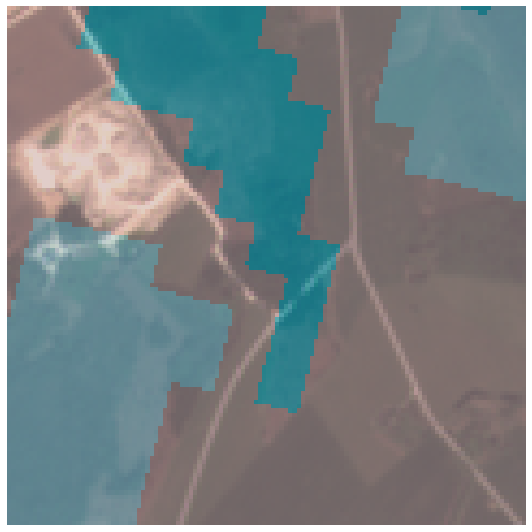

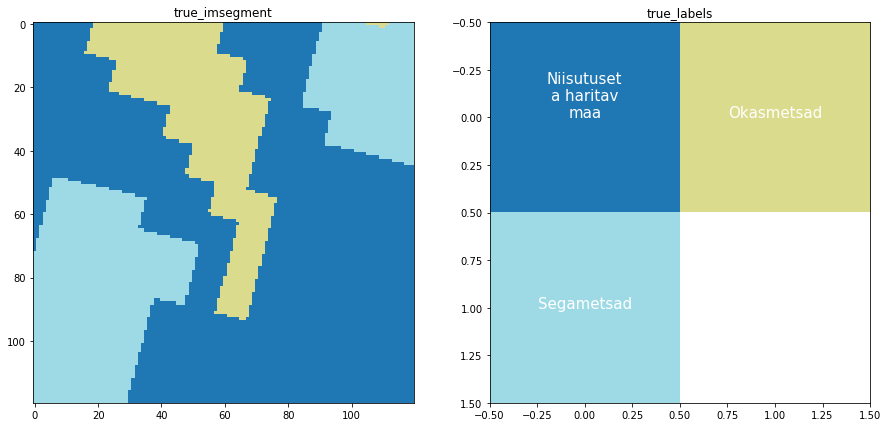

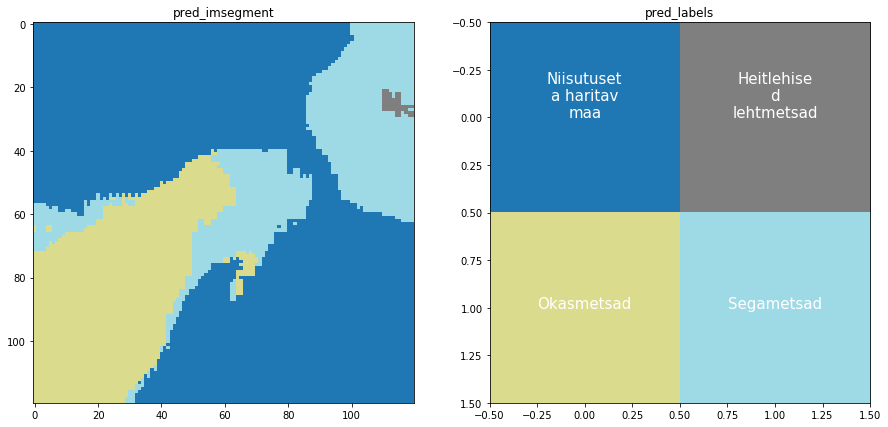

In [28]:
interp.show_xyz(i, sz=15)

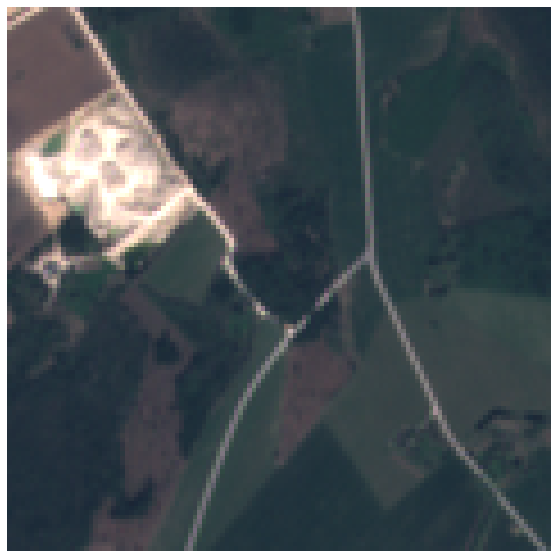

In [29]:
im = open_image(data.valid_ds.items[i])
im.show(figsize=(10, 10))